In [69]:
import numpy as np
import math
import scipy #FEF 

from numpy import exp
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
from scipy.integrate import cumtrapz, quad
from scipy.special import erf

from WIMpy import DMUtils as DMU

import paleopy as paleopy

import os.path
import matplotlib.pyplot as plt

# Spontaneous fission from  $^{238}_{92}U$ from GEF

In [70]:
def energySFF(A0,Z0,B0,A1,Z1,B1,A2,Z2,B2): #calcola l'energia cinetica di due particelle (0 padre, 1 e 2 i figli)
                                           #A il numero di massa, Z il numero atomico e B la binding energy
    mp = 938.3 #MeV
    mn = 939.6 #MeV

    M  = Z0*mp + (A0-Z0)*mn - B0*A0   #calcole le masse (togliendo giustamente la B.E.)
    m1 = Z1*mp + (A1-Z1)*mn - B1*A1
    m2 = Z2*mp + (A2-Z2)*mn - B2*A2

    Ek1 = (M**2 + m1**2 - m2**2)/(2*M) - m1  #energie cinetiche
    Ek2 = (M**2 + m2**2 - m1**2)/(2*M) - m2
    
    return Ek1,Ek2

In [71]:
Z0,A0,E0 = np.loadtxt("U238.dat", usecols = (1,2,3), unpack='true') #prende i dati dell'Uranio238 come padre

In [72]:
#leggo Z, A e B dal file BindingEne e li metto in 3 liste diverse
Z_list,A_list,B_list = np.loadtxt("BindingEne.txt", usecols = (0,1,2), unpack='true') 

Z = [] #Z dei prodotti di fissione
A = [] #A dei prodotti di fissione
E = [] #K dei prodotti di fissione
Z_list0 = [] 
A_list0 = []

N0 = len(Z0) #lunghezza dell'array Z0

for i in range (int(N0/3)): #loop ogni 3 elementi di Z0 (ogni nuovo prodotto)
    z1 = Z0[3*i + 1] #riscrive in nuovi array i Z e A dei prodotti di fissione
    a1 = A0[3*i + 1]
    z2 = Z0[3*i + 2]
    a2 = A0[3*i + 2]

    if(z1 not in Z):        #se z1 e/o z2 non sono gia in Z li scrive in Z_list0
        Z_list0.append(z1)
        A_list0.append(a1)
            
    if(z2 not in Z):            
        Z_list0.append(z2)
        A_list0.append(a2)
            
    Z.append(Z0[3*i + 1])  #mette i prodotti della fissione nell'array Z
    A.append(A0[3*i + 1])
        
    Z.append(Z0[3*i + 2])
    A.append(A0[3*i + 2])
    
    b1 = 0
    b2 = 0
    
    for j in range(len(Z_list)): #loop che scrive le energie di legame dei vari prodotti della fissione che compaiono nella lista
        if(z1 == Z_list[j] and a1 == A_list[j]):
            b1 = B_list[j]            
        if(z2 == Z_list[j] and a2 == A_list[j]):
            b2 = B_list[j]
            
    e1,e2 = energySFF(238,92,7.570126,a1,z1,b1,a2,z2,b2) #calcola le K con funzione sopra, padre Uranio238 e figli i vari prodotti che ha trovato
        
    E.append(e1) # MeV #inserisce le K calcolate in liste di energia
    E.append(e2)

        
N = len(Z) #lunghezza della lista con i prodotti della fissione
M = len(Z_list) #lunghezza della lista con tutti i possibili Z dei prodotti di fissione

# Z[] contains all the possible Z which comes from 238U fission organized as: Z1,Z2,Z1,Z2...(Z1<Z2). 
# A[] contains their atomic number
# E[] contains their kinetik energy

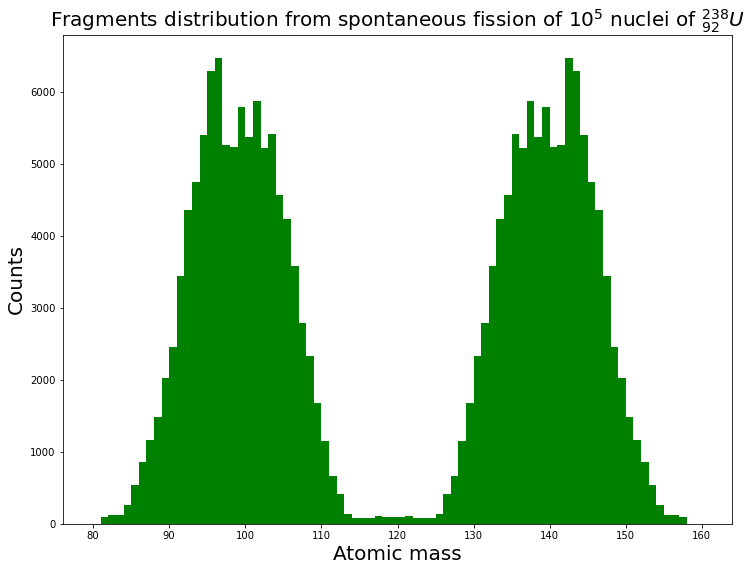

In [73]:
fig = plt.subplots(figsize =(12, 9))
plt.hist(A, 80, range = (80,160),color='g') #80 sono i bins
plt.title(r"Fragments distribution from spontaneous fission of $10^5$ nuclei of $^{238}_{92}U$", fontsize = 20)
plt.xlabel("Atomic mass", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.savefig("FissionFrag.png",bbox_inches="tight")
plt.show()

## SRIM: energy to projected range 

In [74]:
track = [] #lista che contiene la  lunghezza delle tracce di ciascun frammento di fissione

#informazioni sui minerali e le loro formule fisiche

nuclei = {"Gypsum":" H- O-Ca- S", "Halite":"Na-Cl.txt", "Obsidian":"Si-Al-Fe-Ca-Na- K- O.txt", 
              "Cerussite":" O-Pb- C.txt", "Pyromorphite":"Pb- P- O-Cl.txt", "Zircon":"Zr-Si- O.txt"} #FEF ho aggiunto la formula chimica dello Zircone

mineral = "Zircon" #minerale selezionato
nuclei = nuclei[mineral] #prende la formula chimica
mineral += "/" #serve per creare path con il nome del minerale poi

appo = 0 #valori intermedi delle tracce

for i in range(N): #loop su tutti i frammenti di fissione
    
    if(i%10000 == 0): #verifica, stampa un indice ogni 104
        print(i)
    
    # e takes the energy of the fragment, x and y take the range obtained in the material from files
    # la prima parte e per capire da quale directory prendere i dati, poi quali colonne considerare
    #unit_e e unit_x sono per immagazzinare le unità di misura

    e,x,y  = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = (0,4,8), unpack='true')
    unit_e = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 1, dtype = str, unpack='true')
    unit_x = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 5, dtype = str, unpack='true')
    
    n = len(unit_e)  #conversione delle unità di misura
    
    for j in range(n):    
        if(unit_x[j] == "um"): #in nanometri
            x[j] *= 1e3
        else:
            x[j] *= 0.1
            
        if(unit_e[j] == "eV"): #in keV
            e[j] *= 1e-3
        elif(unit_e[j] == "MeV"):
            e[j] *= 1e3
            
    Etox = InterpolatedUnivariateSpline(e,x,k = 1) #funzione di scipy che fa interpolazione lineare

    if (i % 2 == 0):   #si converte in keV l'energia del frammento
        appo = Etox(E[i]*1e3)
        #length by the lighter fragment
    else: #range aggiunto per il secondo frammento
        appo += Etox(E[i]*1e3)        
        track.append(appo) #traccia come somma dei due frammenti
        #sum of the length by the 2 objects
        

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [75]:
n_bins = 200
x_min = 1 #log scale in nm #FEF modificato per vedere cosa succede nei cm #rimodificato al valore originale
x_max = 5 #log scale in nm

#I consder the range between 1 nm and 10^5 nm

In [76]:
lenght = np.logspace(x_min,x_max,n_bins) # nm #crea i bins in scala logaritmica
count  = np.zeros(n_bins-1) #conta i frammenti che finiscono in ogni bin per creare l'altezza dell'istogramma 

for i in range(int(N/2)): #su metà dei frammenti
    if(i%10000 == 0): #check sul loop
        print(i)
    for j in range(n_bins-1): #loop su tutti i range di energia
        if(track[i] >= lenght[j] and track[i] < lenght[j+1]): #check se la traccia cade in un certo bin
            count[j] += 1 #aumenta il conteggio dei bin
            #counting the decays which gave a track with length between length[j] and length[j+1]     


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


### Histo

In [77]:
l = np.logspace(x_min,x_max,10000)
R = np.zeros(10000)

for i in range(n_bins-1):
    for j in range(10000):
        if(l[j] < lenght[i+1] and l[j] >= lenght[i]):
            R[j] = count[i]

## Plot & Write

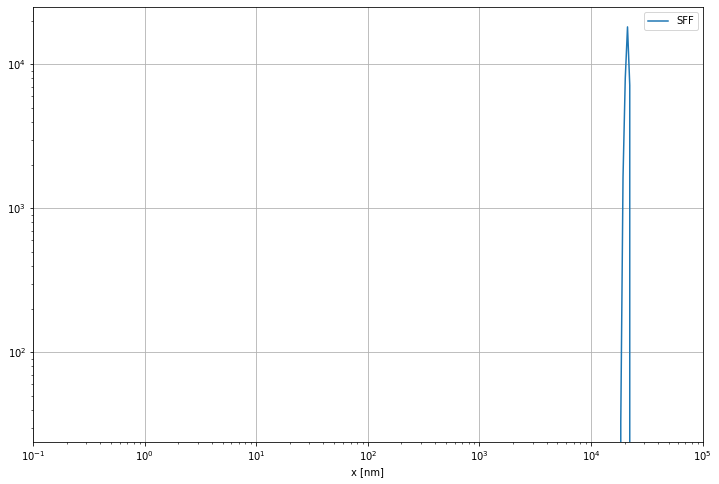

In [78]:
Na  = 6.022e23
tau = 6.45e3 #Myr #tempo di dimezzamento dell'U238
t   = 1.0     #Myr #durata dell'esposizione
# mass = 1 g
#       weight   BR     U-frac    unit mass   decay law

factor = 1e-5*(5.4e-7)*((1.2e-6)*Na*1e3/(238))/tau #numero di eventi di fissione per BR, concentrazione di Uranio, unità di massa (1kg) e rate di decadimento

#BR = 5.4e-7
#f = 1e-5 #to get distribution
#U = Na/238*1e3 #number of atoms in a 1 kg of Uranium
#decays = (1/tau) #number of decays in per Myr
#Ufrac = 1.2*1e-6 # f=1.2 ppm #FEF concentrazione di Uranio nel frammento SANDSTONE MNW283-10 

#factor = f*U*decays*Ufrac

#print(factor)

lenght_width = np.diff(lenght) #range di lunghezza
lenght_mid   = lenght[:-1] + lenght_width/2 #punto medio delle lunghezze del singolo bin

plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.loglog(lenght_mid,count*factor/lenght_width, label='SFF') #lunghezza x e numero di rinculi per unità di lunghezza y
ax = plt.gca()
#plt.title("Recoils spectra in Obsidian from spontaneous fission of ^{238}_{92}U")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
#plt.ylabel("dR/dx [Myr^-1 nm^-1 kg^-1]")
plt.xlabel("x [nm]")
plt.grid()
plt.legend()
plt.xlim(0.1,1e5)
#plt.savefig("Muon_nucRecoil.jpg",bbox_inches="tight")
plt.show()

## Codice modificado da me

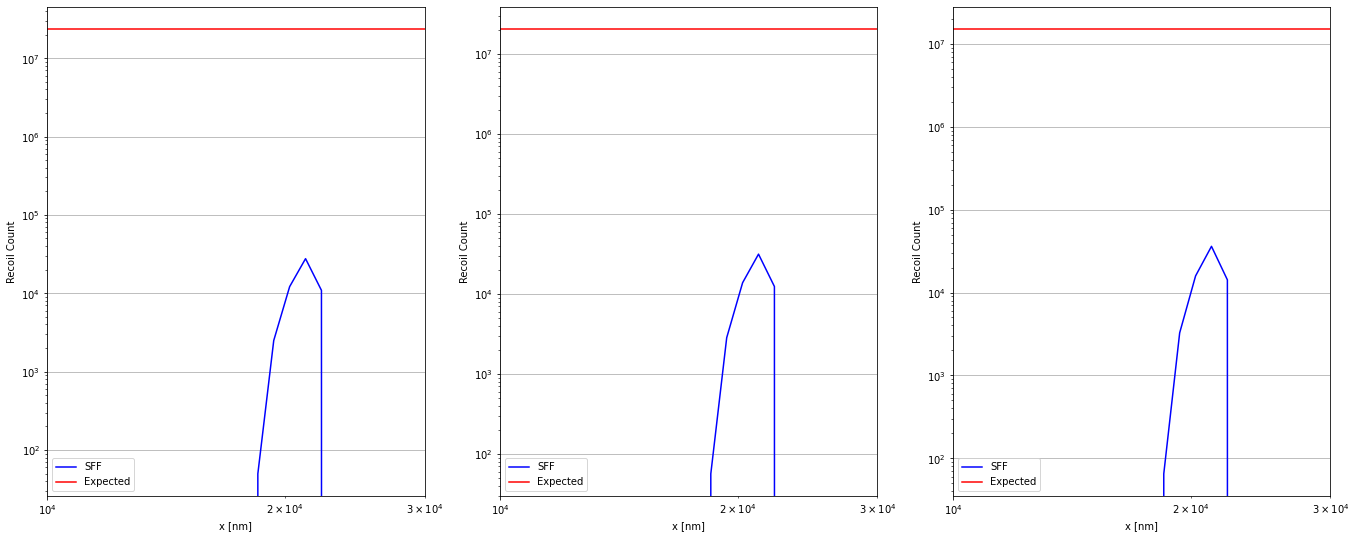

In [79]:
Na  = 6.022e23
tau = 6.45e3 #Myr #tempo di dimezzamento dell'U238
t   = 1.0     #Myr #durata dell'esposizione
U_frac = [1.82e-6, 2.07e-6, 2.38e-6]  #concentrazioni di Uranio per ogni campione (ppm)
density = [235.82e5, 204.98e5, 151.90e5]  #densità misurate nel paper da comparare

#creo 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(23, 9))

# mass = 1 g

for i, U_frac in enumerate(U_frac):
    #       weight   BR     U-frac    unit mass   decay law

    factor = 1e-5*(5.4e-7)*((U_frac)*Na*1e3/(238))/tau #numero di eventi di fissione normalizzati alla concentrazione di Uranio, rate di decadimento e BR

#BR = 5.4e-7
#f = 1e-5 #to get distribution
#U = Na/238*1e3 #number of atoms in a 1 kg of Uranium
#decays = (1/tau) #number of decays in per Myr
#Ufrac = 1.2*1e-6 # f=1.2 ppm #FEF concentrazione di Uranio nel frammento SANDSTONE MNW283-10 

#factor = f*U*decays*Ufrac

#print(factor)

    lenght_width = np.diff(lenght) #range di lunghezza
    lenght_mid   = lenght[:-1] + lenght_width/2 #punto medio delle lunghezze

#plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
    axes[i].loglog(lenght_mid,count*factor/lenght_width, label='SFF', color='blue') #lunghezza x e numero di rinculi per unità di lunghezza y
    paper_values = np.full(len(lenght_mid), density[i]) 
    axes[i].loglog(lenght_mid, paper_values, label='Expected', color='red') #plot dei valori del paper

    ax = plt.gca() #cos'è?
#plt.title("Recoils spectra in Obsidian from spontaneous fission of ^{238}_{92}U")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
#plt.ylabel("dR/dx [Myr^-1 nm^-1 kg^-1]")
    axes[i].set_xlabel("x [nm]")
    axes[i].set_ylabel("Recoil Count")
    axes[i].grid()
    axes[i].legend()
    axes[i].set_xlim(1e4,3e4) #FEF modificato per vedere cosa succede nei cm (valori originari (0.1,1e5)) (1.7e4,2.4e4)=0.017 e 0.024 cm, 17 e 24 um
#plt.savefig("Muon_nucRecoil.jpg",bbox_inches="tight")
plt.show()

In [80]:
f = open("Zircon_fission.dat", "w")
print("# Spontaneous Fission Fragments of Uranium-238", file = f)
print("# Data from GEF", file = f)
print("# x [nm] , MNW283-10 [tracks/cm^2] , PA770-7 [tracks/cm^2] , PA797-2 [tracks/cm^2]", file=f) # FEF questo quello originale print("# x [nm] , dR/dx [1/nm/kg/Myr]", file = f)

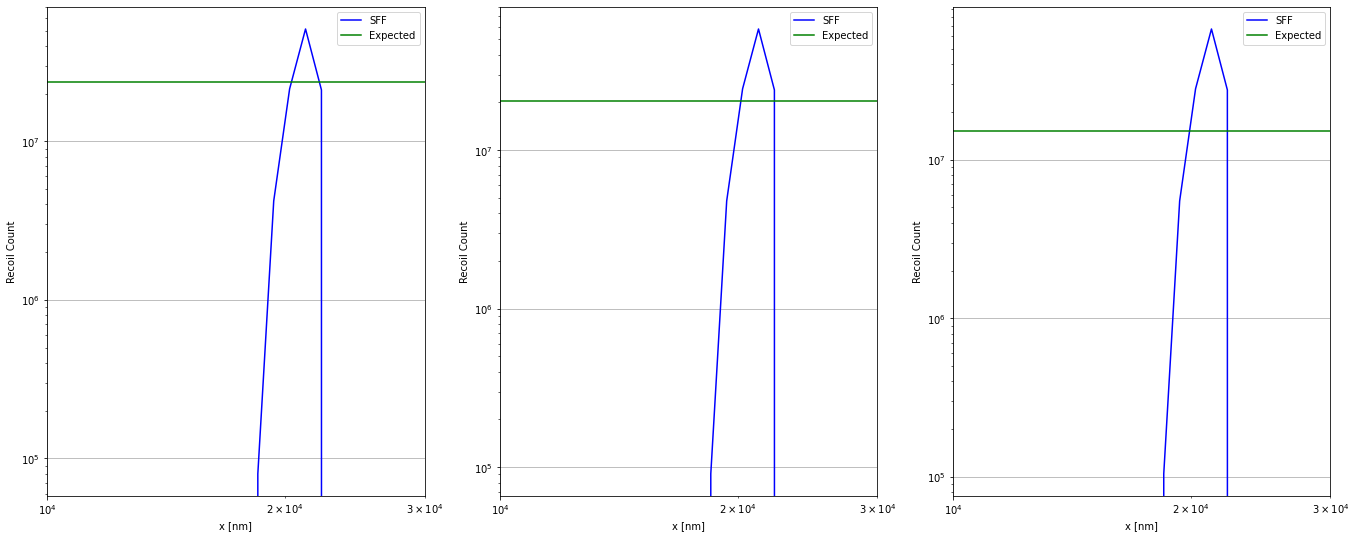

In [103]:
Na  = 6.022e23 #numero di Avogadro
tau = 6.45e3 #Myr #vita media dell'U238
t   = 1.0     #Myr #durata dell'esposizione
U_frac = [1.82e-6, 2.07e-6, 2.38e-6]  #concentrazioni di Uranio per ogni campione (ppm)
density = [235.82e5, 204.98e5, 151.90e5]  #densità misurate nel paper da comparare
zircon_density = 4.65  #g/cm^3

sff_tot=np.zeros(3)#FEF array con le somme di tutte le tracce, 3 dim perchè una per ogni valore di U_frac

#creo 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(23, 9))

# mass = 1 g

for i, U_frac in enumerate(U_frac):
    #       weight   BR     U-frac    unit mass   decay law

    factor = 1e-5*(5.4e-7)*((U_frac)*Na*1e3/(238))/tau #numero di eventi di fissioneper 1 kg di Uranio, la concentrazione, vita media e BR
    

    sff=count*factor*500*zircon_density*2e-3*4/pow(math.pi,2) #densità di tracce al cm^2 che sono contate in ciascun bin (500 Myr, 2e-3 correzione per i cm, 4 e pi sono la media sugli angoli in 3 dim)
    sff_tot[i] = np.sum(sff[sff != 0])  # Somma solo gli sff non nulli    
    paper_values = np.full(len(lenght_mid), density[i])
    difference=count*factor*1e6*zircon_density*1e-7-paper_values
#BR = 5.4e-7
#f = 1e-5 #to get distribution
#U = Na/238*1e3 #number of atoms in a 1 kg of Uranium
#decays = (1/tau) #number of decays in per Myr
#Ufrac = 1.2*1e-6 # f=1.2 ppm #FEF concentrazione di Uranio nel frammento SANDSTONE MNW283-10 

#factor = f*U*decays*Ufrac

    lenght_width = np.diff(lenght) #range di lunghezza
    lenght_mid   = lenght[:-1] + lenght_width/2 #punto medio delle lunghezze

#plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
    axes[i].loglog(lenght_mid, sff, label='SFF', color='blue') #lunghezza x e numero di rinculi per unità di lunghezza y #FEF moltiplico per il tempo di esposizione e per la densità del minerale
    axes[i].loglog(lenght_mid, paper_values, label='Expected', color='green') #plot dei valori del paper
    #calcola la differenza tra i due dati
    #axes[i].loglog(lenght_mid, abs(difference), label='|Difference|', color='red')

    #scrivo i dati nel file di output
    #for j in range(nbin-1):
        
    #print("Lunghezza di U_frac:", len(U_frac))

    #print("Lunghezza di difference:", len(difference))
    #print(U_frac)

    ax = plt.gca() #cos'è?
#plt.title("Recoils spectra in Obsidian from spontaneous fission of ^{238}_{92}U")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
#plt.ylabel("dR/dx [Myr^-1 nm^-1 kg^-1]")
    axes[i].set_xlabel("x [nm]")
    axes[i].set_ylabel("Recoil Count")
    axes[i].grid(True)
    axes[i].legend()
    axes[i].set_xlim(1e4,3e4) #FEF modificato per vedere cosa succede nei cm (valori originari (0.1,1e5)) (1.7e4,2.4e4)=0.017 e 0.024 cm, 17 e 24 um
#plt.savefig("Muon_nucRecoil.jpg",bbox_inches="tight")
f.close()
plt.show()

In [115]:
d = open("Zircon_fission_delta.dat", "w")
print("# Spontaneous Fission Fragments of Uranium-238", file = d)
print("# Data from GEF", file = d)
print("# U-frac\t rho_expected [tracks/cm^2]\t rho_sff [tracks/cm^2]\t delta", file=d) #tabella che contiene la correzione da moltiplicare al codice per ottenere risultati reali

U_frac = [1.82e-6, 2.07e-6, 2.38e-6]  #concentrazioni di Uranio per ogni campione (ppm)
density = [235.82e5, 204.98e5, 151.90e5]  #densità misurate nel paper da comparare

for i in range(0,3):
    print("{:.2e}\t{:.4e}\t{:.4e}\t{:.4}\t{:.4}".format(U_frac[i], density[i], sff_tot[i], sff_tot[i]/density[i], density[i]/sff_tot[i]), file=d) #stampa i vari valori in notazione scientifica e separati da un tab

d.close()
